In [1]:
!pip install transformers==3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.6/754.6 KB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 69.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=a2bea2807ea0877e4a4efbca1818e6b63fc45c94b90ecf4f97ba79b174e9b862
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig, DistilBertTokenizer, DistilBertModel

In [5]:
raw_data_path = "/content/updated_resume_dataset_entities.csv"
# destination_folder = '/content/'

df_raw =  pd.read_csv(raw_data_path)
# df_raw = df_raw.head(1000)
df_raw

,Text,Skills,Education,Experience,Additional_Information,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer
0,Information Technology Manager Information Tec...,IT Management Exchange Network Administration ...,High school or equivalent Cascade High School ...,Information Technology Manager Pacific Coast S...,NaN,0,0,1,0,0,0,0,1,0,0
1,Senior Systems Engineer Senior Systems Enginee...,Windows Server (10+ years) Exchange (10+ years...,NaN,Senior Systems Engineer Infinity Consulting So...,NaN,0,0,0,0,0,0,0,1,0,0
2,Corporate Travel Agent Corporate Travel Agent ...,Tourism CDR (Less than 1 year) Booking AS400 (...,High school,Corporate Travel Agent American Express Global...,SOFT SKILLS Attention to detail Able to sho...,0,0,1,0,1,0,1,0,0,0
3,System Engineer Samsung Austin Semiconductor S...,Css Mysql Java Samsung Austin Semiconductor C...,Bachelor in Computer in Computer Texas State U...,System Engineer Samsung Austin Semiconductor S...,NaN,1,0,0,0,0,0,0,1,0,0
4,Information Security Analyst Information Secur...,testing best practices (Less than 1 year) Secu...,B.S.,Information Security Analyst Webroot May 2015 ...,Skills Exceptional oral and written communic...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29775,Job Seeker Paducah KY Work Experience Wal-Mart...,Soccer Referee Team player Microsoft office Po...,P-12 May 2016 Elementary Education P-5 Emphas...,Wal-Mart - Paducah KY June 2018 to Present You...,NaN,0,0,1,0,0,0,0,0,0,0
29776,IT Senior Analyst Critical Site Reliability Op...,Critical Analysis Problem Solving Java Glo...,B.A.,IT Senior Analyst Critical Site Reliability Op...,NaN,0,0,0,0,0,0,1,0,0,0
29777,Network Operator/ Systems Engineer Network Ope...,T1 Ds3 Ethernet Mysql Telnet Sql Cisco Iphone ...,Bachelors in Computer Science Park University ...,Network Operator/ Systems Engineer United Stat...,NaN,0,0,1,0,0,0,1,1,0,0
29778,Driver Mentor Driver amp Mentor Web Graphic ...,Adobe eMarketing & Web Designer (Contractor) D...,Bachelor of Arts in Media Arts in Web and Inte...,Driver Mentor Lyft Inc August 2014 to Present...,NaN,1,1,0,1,0,0,0,0,0,0


In [6]:
(df_raw[df_raw['Skills'].isna()]).count()

Text                      4298
Skills                       0
Education                 3713
Experience                4297
Additional_Information    1527
Software_Developer        4298
Front_End_Developer       4298
Network_Administrator     4298
Web_Developer             4298
Project_manager           4298
Database_Administrator    4298
Security_Analyst          4298
Systems_Administrator     4298
Python_Developer          4298
Java_Developer            4298
dtype: int64

In [7]:
df_raw[df_raw['Skills'].isna()]

,Text,Skills,Education,Experience,Additional_Information,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer
7,Python Developer Python Developer Python Devel...,NaN,NaN,Python Developer Fox Interactive - Los Angeles...,Technical Skills Operating Systems Windows 9...,1,0,0,0,0,0,0,0,1,1
13,Python Developer Python Developer Python Devel...,NaN,NaN,Python Developer eVarient - Waynesboro VA US J...,NaN,1,0,0,0,0,0,0,0,1,0
29,Java Backend Developer Java Backend Developer ...,NaN,NaN,Java Backend Developer ADP Pvt Ltd November 20...,PRIMARY SKILLS Technologies C C JDBC Java SE...,1,0,0,0,0,0,0,0,1,1
33,Sr Java/JEE Programmer Sr Java/JEE Programmer ...,NaN,Masters,Sr Java/JEE Programmer Dish Network - Englewoo...,NaN,1,0,0,0,0,0,0,0,0,1
36,Software Developer Software Developer Software...,NaN,Master of Science in Computer Science Maharish...,Software Developer Fils La Lotto Center - Port...,SKILLS Languages Java Android Kotlin C. Web...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29733,Front- End Web Developer Front-End Web Develop...,NaN,2yr BA in Graphic Design Cape Technikon Univer...,Front- End Web Developer Symfony - Cape Town W...,NaN,1,1,0,1,0,0,0,0,0,0
29735,IT Project Coordinator IT Project Coordinator ...,NaN,NaN,IT Project Coordinator Johnson Controls - Milw...,NaN,0,0,0,0,1,0,0,1,0,0
29738,Instructor Instructor Senior Software Engineer...,NaN,NaN,Instructor Instructional 2016 to Present Pione...,NaN,0,0,0,0,0,0,0,1,0,0
29769,Digital Developer Digital Developer Atlanta GA...,NaN,Bachelor of Arts in Political Science Bowling ...,Digital Developer J. Walter Thompson - Atlanta...,NaN,1,1,0,0,1,0,0,0,0,0


In [8]:
df_raw = df_raw[df_raw['Skills'].notna()]

In [9]:
df_raw[df_raw['Experience'].isna()] 

,Text,Skills,Education,Experience,Additional_Information,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer
18190,Job Seeker Associate Director Program Manageme...,Business case Program management Business case...,Master of Professional Studies in Enterprise A...,NaN,EXPERTISE Budget Management Process Improveme...,0,0,0,0,0,0,0,0,0,0


In [10]:
df_raw = df_raw[df_raw['Experience'].notna()]

In [11]:
df_raw.shape

(25481, 15)

In [12]:
df_raw.columns

Index(['Text', 'Skills', 'Education', 'Experience', 'Additional_Information',
       'Software_Developer', 'Front_End_Developer', 'Network_Administrator',
       'Web_Developer', 'Project_manager', 'Database_Administrator',
       'Security_Analyst', 'Systems_Administrator', 'Python_Developer',
       'Java_Developer'],
      dtype='object')

In [13]:
df_raw['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']].values.tolist()

In [14]:
df = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']]
df['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']].values.tolist()
df['Skills+Experience'] = df_raw['Skills']+" "+df_raw['Experience']

<ipython-input-14-e1021fc39b2c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
<ipython-input-14-e1021fc39b2c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Skills+Experience'] = df_raw['Skills']+" "+df_raw['Experience']


In [15]:
# df['RolesSkills'] = [''.join(l) for l in df_raw['Roles_Skills']]
# df['RolesSkills'] = df_raw['Roles_Skills'].apply(eval).apply(' '.join)
# # df['RolesSkills'] = df_raw['Roles_Skills'].apply(lambda x: ''.join(x))
# df['Skills+Experience'] = df['RolesSkills']+" "+df_raw['Experience']
# df['Experience']=df_raw['Experience']

In [16]:
df

,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer,target_list,Skills+Experience
0,0,0,1,0,0,0,0,1,0,0,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]",IT Management Exchange Network Administration ...
1,0,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",Windows Server (10+ years) Exchange (10+ years...
2,0,0,1,0,1,0,1,0,0,0,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 0]",Tourism CDR (Less than 1 year) Booking AS400 (...
3,1,0,0,0,0,0,0,1,0,0,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0]",Css Mysql Java Samsung Austin Semiconductor C...
4,0,0,0,0,0,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",testing best practices (Less than 1 year) Secu...
...,...,...,...,...,...,...,...,...,...,...,...,...
29775,0,0,1,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",Soccer Referee Team player Microsoft office Po...
29776,0,0,0,0,0,0,1,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",Critical Analysis Problem Solving Java Glo...
29777,0,0,1,0,0,0,1,1,0,0,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0]",T1 Ds3 Ethernet Mysql Telnet Sql Cisco Iphone ...
29778,1,1,0,1,0,0,0,0,0,0,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0]",Adobe eMarketing & Web Designer (Contractor) D...


In [ ]:
# df['WORD_COUNT'] = df['Experience'].apply(lambda x: len(x.split()))

In [ ]:
# df_raw.hist('WORD_COUNT', bins=30)

In [17]:
df2 = df[['Skills+Experience', 'target_list']].copy()
df2['Skills+Experience'][1]

'Windows Server (10+ years) Exchange (10+ years) Vmware (10+ years) Citrix (3 years) Firewalls (10+ years) Senior Systems Engineer Infinity Consulting Solutions - Brooklyn Park MN April 2019 to Present Provided administration across all systems assisted in company wind down/migration operations decommissioned systems from environment replaced failed servers collaborated with cross-functional teams.'

In [18]:
df2

,Skills+Experience,target_list
0,IT Management Exchange Network Administration ...,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]"
1,Windows Server (10+ years) Exchange (10+ years...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
2,Tourism CDR (Less than 1 year) Booking AS400 (...,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 0]"
3,Css Mysql Java Samsung Austin Semiconductor C...,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,testing best practices (Less than 1 year) Secu...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
...,...,...
29775,Soccer Referee Team player Microsoft office Po...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
29776,Critical Analysis Problem Solving Java Glo...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
29777,T1 Ds3 Ethernet Mysql Telnet Sql Cisco Iphone ...,"[0, 0, 1, 0, 0, 0, 1, 1, 0, 0]"
29778,Adobe eMarketing & Web Designer (Contractor) D...,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
# # Sections of config

# # Defining some key variables that will be used later on in the training
# MAX_LEN = 256
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 4
# LEARNING_RATE = 1e-05

# import torch
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# # model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# # inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# # with torch.no_grad():
# #     logits = model(**inputs).logits

# # predicted_class_id = logits.argmax().item()
# # model.config.id2label[predicted_class_id]

# # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [19]:
# # Sections of config

# # Defining some key variables that will be used later on in the training
# MAX_LEN = 256
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 4
# LEARNING_RATE = 1e-05
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [20]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Skills+Experience']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [21]:
train_size = 0.8
train_dataset = df2.sample(frac=train_size,random_state=200)
valid_dataset = df2.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df2.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

FULL Dataset: (25481, 2)
TRAIN Dataset: (20385, 2)
TEST Dataset: (5096, 2)


In [22]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [23]:
len(training_loader)

5097

In [24]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 10)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistilBERTClass()
model.to(device)

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [25]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [26]:
len(training_loader)

5097

In [27]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [28]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [29]:
#to use as global variables
val_targets=[]
val_outputs=[] 

In [30]:
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      # save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        # save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [31]:
checkpoint_path = '/content/current_checkpoint.pt'
best_model = '/content/best_model.pt'
trained_model = train_model(1, 2, np.Inf, training_loader, validation_loader, model, optimizer, checkpoint_path, best_model)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000042 	Average Validation Loss: 0.000138
Validation loss decreased (inf --> 0.000138).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000032 	Average Validation Loss: 0.000132
Validation loss decreased (0.000138 --> 0.000132).  Saving model ...
############# Epoch 2  Done   #############



In [32]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
val_preds

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.5575941915227629
F1 Score (Micro) = 0.811298148924699
F1 Score (Macro) = 0.7791707038630823


In [34]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [35]:
cm_labels = ['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']
    
cm = mcm(val_targets, val_preds)

In [36]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5240
           1       0.90      0.69      0.78      1416
           2       0.91      0.60      0.73      1480
           3       0.78      0.64      0.70      2378
           4       0.89      0.65      0.75      1600
           5       0.91      0.67      0.77      1042
           6       0.89      0.66      0.76      1102
           7       0.85      0.63      0.73      1956
           8       0.89      0.78      0.83       898
           9       0.86      0.75      0.80      1118

   micro avg       0.89      0.74      0.81     18230
   macro avg       0.88      0.70      0.78     18230
weighted avg       0.89      0.74      0.81     18230
 samples avg       0.84      0.75      0.77     18230



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

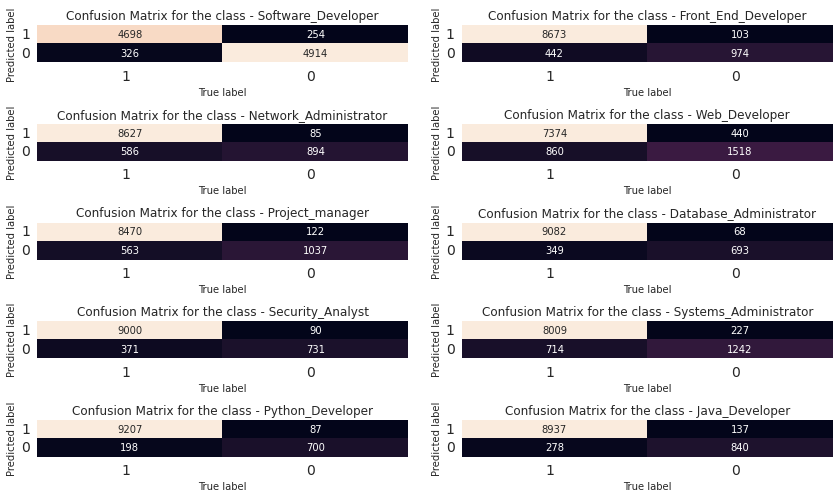

In [38]:
#print_confusion_matrix(mcm(targets, val_preds),class_label=labels, class_names=labels)
sns.set_style("whitegrid")
fig, ax = plt.subplots(5, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()